In [1]:
import bayesfast as bf

In [2]:
from distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)
client

/global/homes/n/nleslie/.conda/envs/cosmosis/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:43519 Dashboard: http://127.0.0.1:39903/status,Cluster Workers: 4 Cores: 4 Memory: 540.15 GB


In [3]:
import numpy as np

N = 10000 # number of samples to generate; the actual size may be smaller because of the prior
D = 16 # number of dims
a = 1.
b = 0.5

def logp(x):
    n = x.shape[-1]
    _a = -0.5 * x[..., 0]**2 / a**2
    _b = -0.5 * np.sum(x[..., 1:]**2, axis=-1) * np.exp(-2 * b * x[..., 0])
    _c = (-0.5 * np.log(2 * np.pi * a**2) - 
          0.5 * (n - 1) * np.log(2 * np.pi) - (n - 1) * b * x[..., 0])
    return _a + _b + _c

def grad(x):
    n = x.shape[-1]
    foo = -x / np.insert(np.full((*x.shape[:-1], n - 1), 
                                 np.exp(2 * b * x[..., 0])), 0, a**2, axis=-1)
    foo[0] += b * np.sum(x[..., 1:]**2, axis=-1) * np.exp(-2 * b * x[..., 0])
    foo[0] -= (n - 1) * b
    return foo

In [4]:
den = bf.DensityLite(logp=logp, grad=grad, input_size=D)

In [5]:
import numpy as np
from bayesfast.utils import random as bfrandom
D = 16
x_test = bfrandom.multivariate_normal(
                np.zeros(D), np.eye(D), 1, skip = 100)

def logprior(x):
    return -1/2*np.sum([y**2 for y in x])-D/2*np.log(2*np.pi)

def gradlogprior(x):
    return -x

prior = bf.DensityLite(logp=logprior, grad=gradlogprior, input_size=D)

In [6]:
# from bayesfast.samplers import TTrace
# trace = TTrace(n_iter=6000, n_warmup=1000)
sam = bf.sample(den, prior=prior, client=client, sampler='THMC')

 CHAIN #2 : sampling proceeding [ 300 / 1500 ], last 300 samples used 3.10 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 300 / 1500 ], last 300 samples used 3.18 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 300 / 1500 ], last 300 samples used 3.13 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 300 / 1500 ], last 300 samples used 3.26 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 600 / 1500 ], last 300 samples used 2.58 seconds.
 CHAIN #2 : sampling proceeding [ 600 / 1500 ], last 300 samples used 2.75 seconds.
 CHAIN #3 : sampling proceeding [ 600 / 1500 ], last 300 samples used 3.07 seconds.
 CHAIN #1 : sampling proceeding [ 600 / 1500 ], last 300 samples used 3.51 seconds.
 CHAIN #0 : sampling proceeding [ 900 / 1500 ], last 300 samples used 2.59 seconds.
 CHAIN #2 : sampling proceeding [ 900 / 1500 ], last 300 samples used 2.68 seconds.
 CHAIN #3 : sampling proceeding [ 900 / 1500 ], last 300 samples used 3.07 seconds.
 CHAIN #1 : sampling proceeding [ 900 / 

In [8]:
# sam_nuts = bf.sample(den, client=client)

In [9]:
sam().shape

(4, 1000, 16)

Removed no burn in


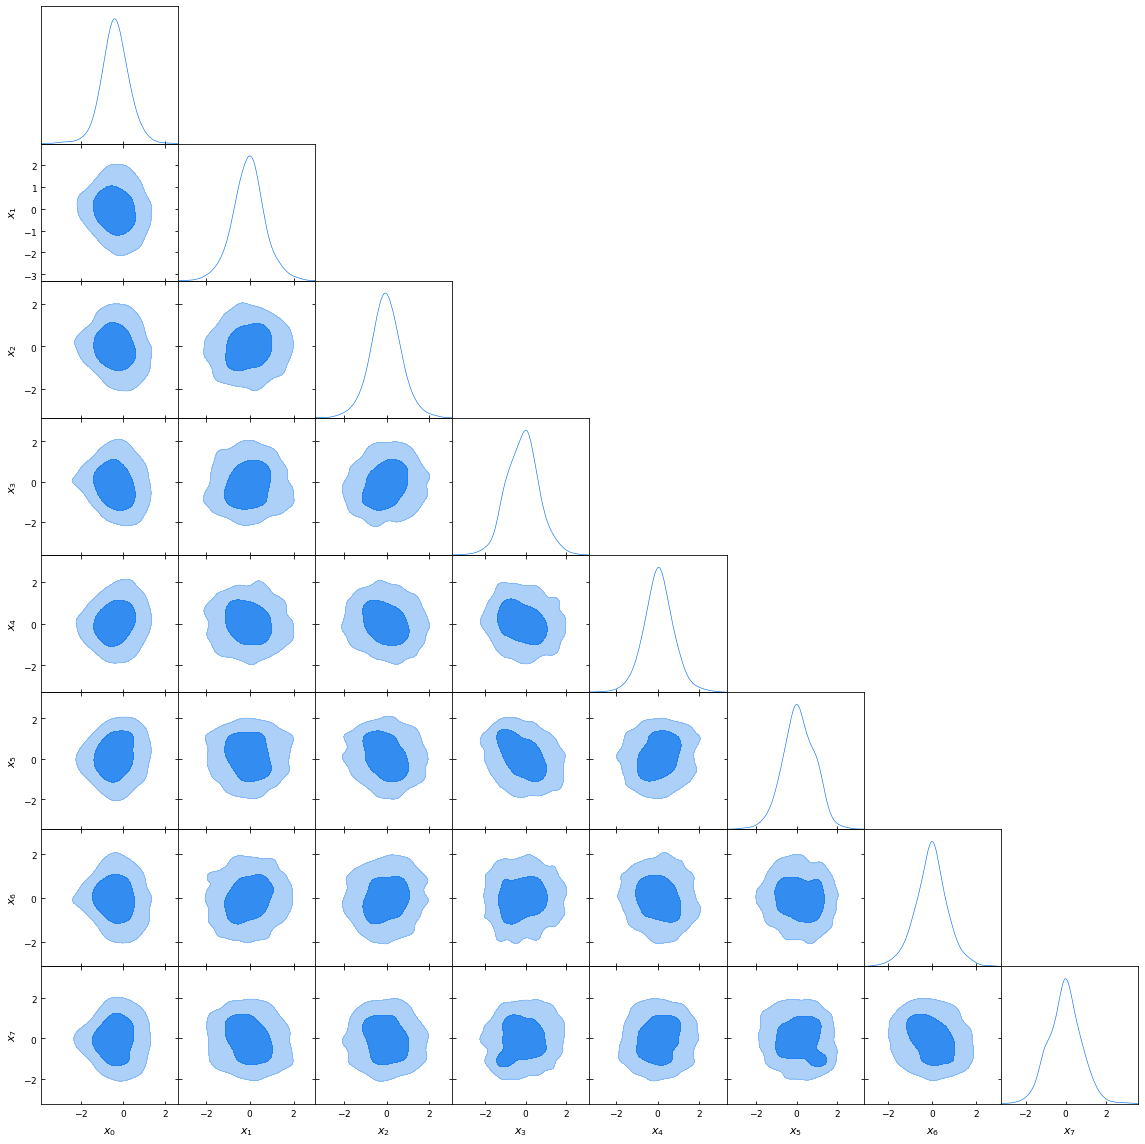

In [10]:
%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt

n_show = 8
names = ["x_%s"%i for i in range(n_show)]
labels = ["x_%s"%i for i in range(n_show)]
s = MCSamples(samples=sam().reshape((-1, D))[:, :n_show], names=names, labels=labels)
g = plots.getSubplotPlotter()
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.triangle_plot([s], filled=True, contour_args={'alpha':0.8})
plt.show()

In [11]:
# 4-D Gaussian Mixture Target
# mu1 = np.array([-0.5, 0.2, -0.3, 0.4])
# sig1 = np.array([0.1, 0.1, 0.1, 0.1])
# mu2 = np.array([0.3, -0.4, 0.1, 0.1])
# sig2 = np.array([0.1, 0.1, 0.1, 0.1])
mu1 = np.array([-0.5, -0.5, -0.5, -0.5])
sig1 = np.array([0.1, 0.1, 0.1, 0.1])
mu2 = np.array([0.4, 0.4, 0.4, 0.4])
sig2 = np.array([0.1, 0.1, 0.1, 0.1])
D = 4

# # 2-D Gaussian Mixture Target
# mu1 = np.array([-0.5, -0.3])
# sig1 = np.array([0.1, 0.1])
# mu2 = np.array([0.3, 0.2])
# sig2 = np.array([0.1, 0.1])
# D = 2

def mvgaussian(x, mu, sigma):
    return np.exp(-1/2*np.sum(((x-mu)/sigma)**2))/np.sqrt(np.product(2*np.pi*sigma))

def d_mvgaussian(x, mu, sigma):
    return (mu-x)/sigma**2*mvgaussian(x, mu, sigma)

def gmp(x):
    return 1/2*( mvgaussian(x, mu1, sig1) + mvgaussian(x, mu2, sig2) )

def gmlogp(x):
    return np.log(gmp(x))

def gradgmlogp(x):
    return (d_mvgaussian(x, mu1, sig1) + d_mvgaussian(x, mu2, sig2))/(mvgaussian(x, mu1, sig1) + mvgaussian(x, mu2, sig2))

# Plot 2-D Gaussian
# def gmp2d(x,y):
#     X = np.array([x,y])
#     return gmp(X)

# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
# from matplotlib import cm
# import numpy as np

# x = np.linspace(-1,1,50)
# y = np.linspace(-1,1,50)
# z = np.zeros((50,50))
# for i in range(50):
#     for j in range(50):
#         z[i][j] = gmp2d(x[i],y[j])

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.contour3D(x, y, z, 50, cmap=cm.coolwarm)
# ax.set_xlabel('$x_0$')
# ax.set_ylabel('$x_1$')
# ax.set_zlabel('p');
# ax.view_init(30,40)       

# plt.show()
origin = np.array([0, 0, 0, 0])
gmlogp(origin)
gradgmlogp(origin)

array([39.99999863, 39.99999863, 39.99999863, 39.99999863])

In [12]:
gmden = bf.DensityLite(logp=gmlogp, grad=gradgmlogp, input_size=D)
gmprior = bf.DensityLite(logp=logprior, grad=gradlogprior, input_size=D)
gmsam = bf.sample(gmden, prior=gmprior, client=client, sampler='THMC')

/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:157: RuntimeWarning:  CHAIN #3 : divide by zero encountered in log
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:157: RuntimeWarning:  CHAIN #3 : invalid value encountered in true_divide
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:157: RuntimeWarning:  CHAIN #1 : divide by zero encountered in log
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:157: RuntimeWarning:  CHAIN #1 : invalid value encountered in true_divide
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:157: RuntimeWarning:  CHAIN #0 : divide by zero encountered in log
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:157: RuntimeWarning:  CHAIN #0 : invalid value encountered in true_divide
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sam

 CHAIN #0 : sampling proceeding [ 300 / 1500 ], last 300 samples used 1.50 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 300 / 1500 ], last 300 samples used 1.64 seconds. (warmup)
 CHAIN #2 : sampling proceeding [ 300 / 1500 ], last 300 samples used 1.73 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 300 / 1500 ], last 300 samples used 1.84 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 600 / 1500 ], last 300 samples used 1.53 seconds.
 CHAIN #2 : sampling proceeding [ 600 / 1500 ], last 300 samples used 1.44 seconds.
 CHAIN #3 : sampling proceeding [ 600 / 1500 ], last 300 samples used 1.34 seconds.
 CHAIN #1 : sampling proceeding [ 600 / 1500 ], last 300 samples used 2.08 seconds.
 CHAIN #3 : sampling proceeding [ 900 / 1500 ], last 300 samples used 1.20 seconds.
 CHAIN #0 : sampling proceeding [ 900 / 1500 ], last 300 samples used 1.52 seconds.
 CHAIN #2 : sampling proceeding [ 900 / 1500 ], last 300 samples used 1.44 seconds.
 CHAIN #1 : sampling proceeding [ 900 / 

In [13]:
gmsam().shape

(4, 1000, 4)

Removed no burn in


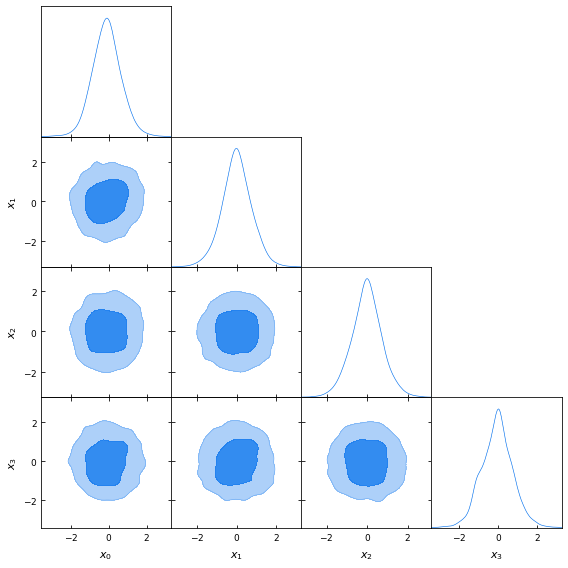

In [14]:
names = ["x_%s"%i for i in range(D)]
labels = ["x_%s"%i for i in range(D)]
s = MCSamples(samples=sam().reshape((-1, D)), names=names, labels=labels)
g = plots.getSubplotPlotter()
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.triangle_plot([s], filled=True, contour_args={'alpha':0.8})
plt.show()

/global/homes/n/nleslie/.conda/envs/cosmosis/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


 CHAIN #3 : sampling proceeding [ 300 / 1500 ], last 300 samples used 6.26 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 300 / 1500 ], last 300 samples used 6.50 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 300 / 1500 ], last 300 samples used 6.99 seconds. (warmup)
 CHAIN #2 : sampling proceeding [ 300 / 1500 ], last 300 samples used 7.18 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 600 / 1500 ], last 300 samples used 6.26 seconds.
 CHAIN #0 : sampling proceeding [ 600 / 1500 ], last 300 samples used 6.60 seconds.
 CHAIN #1 : sampling proceeding [ 600 / 1500 ], last 300 samples used 6.95 seconds.
 CHAIN #2 : sampling proceeding [ 600 / 1500 ], last 300 samples used 7.12 seconds.
 CHAIN #3 : sampling proceeding [ 900 / 1500 ], last 300 samples used 5.97 seconds.
 CHAIN #0 : sampling proceeding [ 900 / 1500 ], last 300 samples used 6.71 seconds.
 CHAIN #1 : sampling proceeding [ 900 / 1500 ], last 300 samples used 6.43 seconds.
 CHAIN #2 : sampling proceeding [ 900 / 

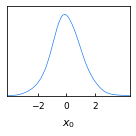

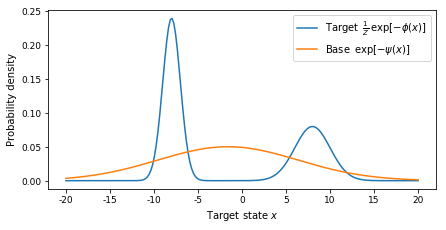

In [3]:
# 1-D Graham '17 example
import bayesfast as bf
import numpy as np
from bayesfast.samplers import TTrace

from distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)

mu_1 = -8
mu_2 = 8
sigma_1 = 1
sigma_2 = 2
p_1 = 0.6
p_2 = 0.4
D=1

var_mean = p_1 * mu_1 + p_2 * mu_2
var_std = (
    p_1 * sigma_1**2 + p_2 * sigma_2**2 + 
    p_1 * mu_1**2 + p_2 * mu_2**2 - var_mean**2
)**0.5

def phi(x):
    return -np.log(
    (p_1 / (2 * np.pi * sigma_1**2)**0.5) * np.exp(-0.5 * ((x - mu_1) / sigma_1)**2) +
    (p_2 / (2 * np.pi * sigma_2**2)**0.5) * np.exp(-0.5 * ((x - mu_2) / sigma_2)**2)
    )

def psi(x):
    return 0.5 * ((x - var_mean) / var_std)**2 + 0.5 * np.log(2 * np.pi) + np.log(var_std)

def mphi(x):
    return np.log(
    (p_1 / (2 * np.pi * sigma_1**2)**0.5) * np.exp(-0.5 * ((x - mu_1) / sigma_1)**2) +
    (p_2 / (2 * np.pi * sigma_2**2)**0.5) * np.exp(-0.5 * ((x - mu_2) / sigma_2)**2)
    )

def gradmphi(x):
    num = (mu_1 - x) / (sigma_1**2) * (p_1 / (2 * np.pi * sigma_1**2)**0.5) * np.exp(-0.5 * ((x - mu_1) / sigma_1)**2) + (mu_2 - x) / (sigma_2**2) * (p_2 / (2 * np.pi * sigma_2**2)**0.5) * np.exp(-0.5 * ((x - mu_2) / sigma_2)**2)

    denom = (p_1 / (2 * np.pi * sigma_1**2)**0.5) * np.exp(-0.5 * ((x - mu_1) / sigma_1)**2) + (p_2 / (2 * np.pi * sigma_2**2)**0.5) * np.exp(-0.5 * ((x - mu_2) / sigma_2)**2)

    return num/denom
    
def mpsi(x):
    return -0.5 * ((x - var_mean) / var_std)**2 - 0.5 * np.log(2 * np.pi) - np.log(var_std)

def gradmpsi(x):
    return (var_mean-x)/var_std**2

testden = bf.DensityLite(logp=mphi, grad=gradmphi, input_size=D)
testprior = bf.DensityLite(logp=mpsi, grad=gradmpsi, input_size=D)
# trace = TTrace(n_iter=6000, n_warmup=1000)
testsam = bf.sample(testden, prior=testprior, client=client, sampler='THMC', n_steps=20, dt=1)
# testsam = bf.sample(testden, client=client, sampler='HMC', dt = 1)

%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt

names = ["x_%s"%i for i in range(D)]
labels = ["x_%s"%i for i in range(D)]
s = MCSamples(samples=testsam().reshape((-1, D)), names=names, labels=labels)
g = plots.getSubplotPlotter()
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.triangle_plot([s], filled=True, contour_args={'alpha':0.8})

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 1, 1)
xs = np.linspace(-20, 20, 200)
ax.plot(xs, np.exp(-phi(xs)))
ax.plot(xs, np.exp(-psi(xs)))
ax.legend([r'Target $\,\frac{1}{Z}\,\exp[-\phi(x)]$', r'Base $\,\exp[-\psi(x)]$'])
ax.set_xlabel(r'Target state $x$')
ax.set_ylabel(r'Probability density')
ax.set_xticklabels(['{0:.0f}'.format(tick) for tick in ax.get_xticks()], fontsize=9)
ax.set_yticklabels(['{0:.2f}'.format(tick) for tick in ax.get_yticks()], fontsize=9)
fig.tight_layout(pad=0)
plt.show()

/global/homes/n/nleslie/.conda/envs/cosmosis/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:184: UserWarning: n_steps not provided. Defaulting to 20 steps for each HMC iteration.
  warnings.warn('n_steps not provided. Defaulting to 20 steps for each HMC iteration.')


 CHAIN #1 : sampling proceeding [ 300 / 1500 ], last 300 samples used 1.75 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 300 / 1500 ], last 300 samples used 1.69 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 300 / 1500 ], last 300 samples used 1.80 seconds. (warmup)
 CHAIN #2 : sampling proceeding [ 300 / 1500 ], last 300 samples used 2.00 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 600 / 1500 ], last 300 samples used 1.68 seconds.
 CHAIN #3 : sampling proceeding [ 600 / 1500 ], last 300 samples used 1.86 seconds.
 CHAIN #0 : sampling proceeding [ 600 / 1500 ], last 300 samples used 1.68 seconds.
 CHAIN #2 : sampling proceeding [ 600 / 1500 ], last 300 samples used 1.83 seconds.
 CHAIN #1 : sampling proceeding [ 900 / 1500 ], last 300 samples used 1.60 seconds.
 CHAIN #0 : sampling proceeding [ 900 / 1500 ], last 300 samples used 1.70 seconds.
 CHAIN #3 : sampling proceeding [ 900 / 1500 ], last 300 samples used 1.80 seconds.
 CHAIN #2 : sampling proceeding [ 900 / 

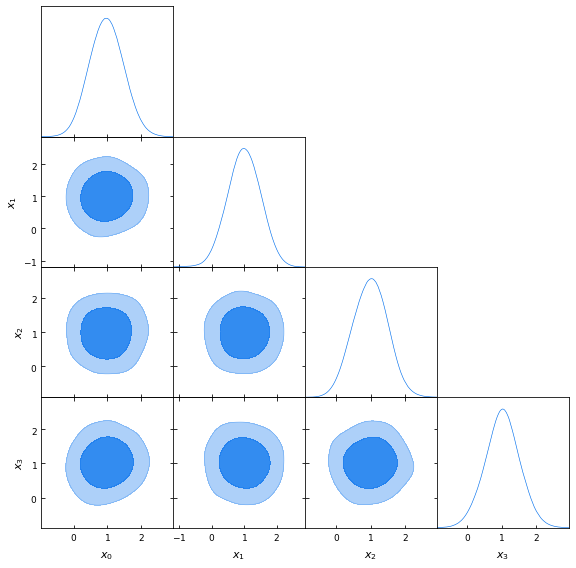

In [4]:
import bayesfast as bf
import numpy as np

from distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)

# 4-D Gaussian Mixture Target
a = 1
b = 0.5
mu1 = np.array([a, a, a, a])
sig1 = np.array([b, b, b, b])
D = 4


def mvgaussian(x, mu, sigma):
    return np.exp(-1/2*np.sum(((x-mu)/sigma)**2))/np.sqrt(np.product(2*np.pi*sigma))

def d_mvgaussian(x, mu, sigma):
    return (mu-x)/sigma**2*mvgaussian(x, mu, sigma)

def loggaussian(x, mu, sigma):
    return -1/2*np.sum(((x-mu)/sigma)**2) - 1/2*np.sum(np.log(2*np.pi*sigma))

def d_loggaussian(x, mu, sigma):
    return (mu-x)/sigma**2

def testlogp(x):
    return loggaussian(x, mu1, sig1)

def testgrad(x):
    return d_loggaussian(x, mu1, sig1)

testden = bf.DensityLite(logp=testlogp, grad=testgrad, input_size=D)
# unit gaussian
# testprior = bf.DensityLite(logp=logprior, grad=gradlogprior, input_size=D)
testsam = bf.sample(testden, client=client, sampler='HMC', dt=1)

%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt

names = ["x_%s"%i for i in range(D)]
labels = ["x_%s"%i for i in range(D)]
s = MCSamples(samples=testsam().reshape((-1, D)), names=names, labels=labels)
g = plots.getSubplotPlotter()
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.triangle_plot([s], filled=True, contour_args={'alpha':0.8})
plt.show()

In [7]:
from collections import namedtuple
NamedTuple = namedtuple('Name', 'item1, item2, item3')
subdict = {'item1': 1, 'item2': 2}
# tup = NamedTuple(**subdict, item3 = 3)

def make_tup(*args, **kwargs):
        return NamedTuple(*args, **kwargs)

tup = make_tup(**subdict, item3 = 3)
print(tup)

Name(item1=1, item2=2, item3=3)
